In [147]:
import bottlenecking as btl
import tensorflow as tf
import numpy as np
import pandas as pd
import uns
from uns import training
from fcn_model import fcn16_vgg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

In [148]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.InteractiveSession(config=config)

In [149]:
sess = tf.InteractiveSession()

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1040d06a0>>
Traceback (most recent call last):
  File "//anaconda/envs/CDIPS/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 138, in __del__
    self.close()
  File "//anaconda/envs/CDIPS/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 784, in close
    self._default_session.__exit__(None, None, None)
  File "//anaconda/envs/CDIPS/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "//anaconda/envs/CDIPS/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2978, in get_controller
    assert self.stack[-1] is default
AssertionError: 


In [150]:
batch_images = tf.placeholder(tf.float32,[None, 416, 576, 3])
#batch_masks = tf.placeholder(tf.float32, [None, 420, 580, 2])  #Size 2 => "yes" and "no"

In [5]:
vgg_path = '../vgg16.npy'

In [6]:
net = fcn16_vgg.FCN16VGG(vgg16_npy_path=vgg_path)

npy file loaded


In [7]:
with tf.name_scope("content_vgg"):
       net.build(batch_images, train=False, num_classes=2, random_init_fc8=True,debug=False)

Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
Layer name: conv4_2
Layer shape: (3, 3, 512, 512)
Layer name: conv4_3
Layer shape: (3, 3, 512, 512)
Layer name: conv5_1
Layer shape: (3, 3, 512, 512)
Layer name: conv5_2
Layer shape: (3, 3, 512, 512)
Layer name: conv5_3
Layer shape: (3, 3, 512, 512)
Layer name: fc6
Layer shape: [7, 7, 512, 4096]
Layer name: fc7
Layer shape: [1, 1, 4096, 4096]


In [8]:
bottleneck=[net.fc6, net.pool4]

In [9]:
btl.get_bottleneck_dims(bottleneck[0])

[13, 18, 4096]

In [10]:
def build_batch_output_w_masks(imgs,masks,path,bottlenecks,sess):
    """writes a single batch to disk"""    
    batch_size = imgs.shape[0]   
    bottles = sess.run(bottlenecks, feed_dict={batch_images:imgs})
    print('Finished running forward passes')
    records = [b.reshape(batch_size, -1) for b in bottles]
    records.append(masks.reshape(batch_size,-1))
    flat_records = np.concatenate(records, axis=1)     
    flat_records.astype('float32').tofile(path)
    msg = 'Output data written to {file}'.format(file=path)
    print(msg)


def build_output_data(session,bottlenecks,batch_size,trainingData,target_dir,name='fc6pool4mask',debug=False):    
    """write a bunch of batches to disk"""
    batches = btl.make_batches(trainingData,batch_size)
    if debug == True:
        batches = batches[:4]
    for i,b in enumerate(batches):
        #images = btl.load_batch(b)
        images, masks = btl.load_batch(b)
        filename = target_dir+name +'_batch_' + str(i+1)
        #build_batch_output(images,filename,bottleneck,session)
        build_batch_output_w_masks(images, masks,filename,bottlenecks,session)

def build_single(session, bottlenecks, trainingData, target_dir):
    """Takes an input of rows from training.bin and runs build_output"""
    imgbatch = uns.batch(trainingData)
    while imgbatch:        
        imgpair = imgbatch.pop()
        imgrgb=np.expand_dims(imgpair.image.load_rgb(trim=2), axis=0)
        bottles = sess.run(bottlenecks, feed_dict={batch_images:imgrgb})        
        record = [b.flatten() for b in bottles]        
        record.append(imgpair.mask.one_hot().flatten())
        flat_record = np.concatenate(record)     
        path = target_dir + imgpair.bottlefile
        flat_record.astype('float32').tofile(path)
        print('{file}'.format(file=path))
    

In [11]:
time sess.run(tf.initialize_all_variables())

CPU times: user 4.02 s, sys: 6.62 s, total: 10.6 s
Wall time: 23.9 s


In [13]:
test= build_output_data(sess,bottleneck,4,training[:5],'/Users/gus/CDIPS/mask_debug/')

Finished running forward passes
Output data written to /Users/gus/CDIPS/mask_debug/fc6pool4mask_batch_1


In [46]:
uns.batch(training[:2])

[<uns.image_pair at 0x11a616dd8>, <uns.image_pair at 0x11a616080>]

In [14]:
loaded = np.fromfile('/Users/gus/CDIPS/mask_debug/fc6pool4mask_batch_1')

In [132]:
loaded.dtype=np.float32

In [141]:
def load_mask(sub,img):
    filename = '/Users/gus/CDIPS/nerve-project/train/{s}_{i}_mask.tif'.format(s=sub,i=img)
    res= io.imread(filename)
    return res

In [89]:
L=1916928

In [90]:
p=416*576*2

In [91]:
n=1916928-p

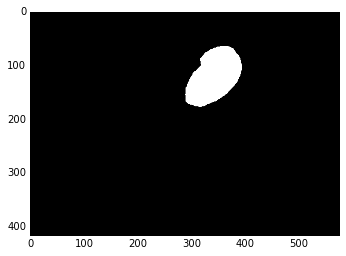

In [95]:
plt.imshow(loaded[3*L-p:3*L].reshape(416,576,2)[:,:,1],cmap="Greys")

In [101]:
loaded_inference=np.load('/Users/gus/CDIPS/fcn_eval_log/predictions_chunk_1.npy')

In [162]:
loaded_inference.shape

(4, 2, 10, 416, 576)

In [165]:
d = loaded_inference.shape
reordered = np.empty((d[0]*d[2],d[1],d[3],d[4]))

for i in range(d[0]):
    for j in range(d[2]):
        idx = j+i*d[2]
        reordered[idx,:,:,:] = loaded_inference[i,:,j,:,:]

In [167]:
reordered.shape

(40, 2, 416, 576)

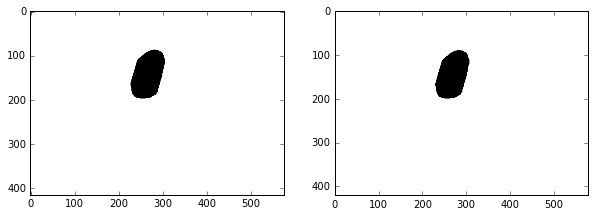

In [161]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(221)
ax1.imshow(np.logical_not(loaded_inference[0,1,5,:,:]).astype(bool),cmap='Greys')
ax2 = fig.add_subplot(222)
plt.imshow(load_mask(1,2),cmap="Greys")

In [16]:
build_single(sess,bottleneck,training,'../bottleneck_files/')

../bottleneck_files/47_120.btl
../bottleneck_files/47_119.btl
../bottleneck_files/47_118.btl
../bottleneck_files/47_117.btl
../bottleneck_files/47_116.btl
../bottleneck_files/47_115.btl
../bottleneck_files/47_114.btl
../bottleneck_files/47_113.btl
../bottleneck_files/47_112.btl
../bottleneck_files/47_111.btl
../bottleneck_files/47_110.btl
../bottleneck_files/47_109.btl
../bottleneck_files/47_108.btl
../bottleneck_files/47_107.btl
../bottleneck_files/47_106.btl
../bottleneck_files/47_105.btl
../bottleneck_files/47_104.btl
../bottleneck_files/47_103.btl
../bottleneck_files/47_102.btl
../bottleneck_files/47_101.btl
../bottleneck_files/47_100.btl
../bottleneck_files/47_99.btl
../bottleneck_files/47_98.btl
../bottleneck_files/47_97.btl
../bottleneck_files/47_96.btl
../bottleneck_files/47_95.btl
../bottleneck_files/47_94.btl
../bottleneck_files/47_93.btl
../bottleneck_files/47_92.btl
../bottleneck_files/47_91.btl
../bottleneck_files/47_90.btl
../bottleneck_files/47_89.btl
../bottleneck_files

/home/chrisv/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


../bottleneck_files/30_74.btl
../bottleneck_files/30_73.btl
../bottleneck_files/30_72.btl
../bottleneck_files/30_71.btl
../bottleneck_files/30_70.btl
../bottleneck_files/30_69.btl
../bottleneck_files/30_68.btl
../bottleneck_files/30_67.btl
../bottleneck_files/30_66.btl
../bottleneck_files/30_65.btl
../bottleneck_files/30_64.btl
../bottleneck_files/30_63.btl
../bottleneck_files/30_62.btl
../bottleneck_files/30_61.btl
../bottleneck_files/30_60.btl
../bottleneck_files/30_59.btl
../bottleneck_files/30_58.btl
../bottleneck_files/30_57.btl
../bottleneck_files/30_56.btl
../bottleneck_files/30_55.btl
../bottleneck_files/30_54.btl
../bottleneck_files/30_53.btl
../bottleneck_files/30_52.btl
../bottleneck_files/30_51.btl
../bottleneck_files/30_50.btl
../bottleneck_files/30_49.btl
../bottleneck_files/30_48.btl
../bottleneck_files/30_47.btl
../bottleneck_files/30_46.btl
../bottleneck_files/30_45.btl
../bottleneck_files/30_44.btl
../bottleneck_files/30_43.btl
../bottleneck_files/30_42.btl
../bottlen

In [11]:
build_output_data(sess,[net.fc6,net.pool4],4,training,'../bottleneck_files/')

Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_1
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_2
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_3
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_4
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_5
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_6
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_7
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_8
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_9
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_10
Finished running forward passes
Output 

/home/chrisv/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_12
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_13
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_14
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_15
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_16
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_17
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_18
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_19
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_20
Finished running forward passes
Output data written to ../bottleneck_files/fc6pool4mask_batch_21
Finished running forward passe